In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%run functions/preprocess.py
%run functions/linear_regression.py

np.set_printoptions(formatter={'float_kind': '{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn')


## Loading the data

In [36]:
df_data = pd.read_pickle('processed2017.pkl')
df_data = df_data.drop(['time of day', 'weekday', 'Unix', 'next_event', 'prev_event',
                        'nextUnix', 'prevUnix', 'prevTime', 'event org:resource'], axis=1)


# should actually be done after splitting
df_data = encode(df_data)
df_data = time_diff(df_data, outlier='keep')

# from sklearn.preprocessing import QuantileTransformer
# rng = np.random.RandomState(0)
# qt = QuantileTransformer(n_quantiles=10, random_state=0)
# df_data['time_diff'] = qt.fit_transform(df_data['time_diff'].to_numpy().reshape(-1, 1))
# plt.plot(X)

df_data.drop(['loangoal_Debt restructuring',
 'eventname_W_Personal Loan collection',
 'action_Deleted',
 'action_Obtained',
 'action_Released',
 'eventname_O_Accepted',
 'eventname_W_Assess potential fraud',
 'origin_Workflow',
 'hour',
 'action_statechange',
 'loangoal_Car',
 'origin_Offer',
 'lifecycle_complete',
 'appl_type_New credit'], axis=1, inplace = True)


In [37]:
def sliding_window(window_size, df):
    """transforms df_data into supervised form 
    with rolling window implementations

    Args:
        window_size (int): size of rolling window

    Returns:
        (X, Y): tuple of input and output arrays
    """

    windows = list(df.rolling(window=window_size))
    for i in windows[window_size-1:]:
        # split into X and Y
        i = i.drop('case concept:name', axis=1)
        temp = i.to_numpy()
        temp = [item for sublist in temp for item in sublist]
        Y.append(temp.pop(-1))
        X.append(temp)
    return None


In [38]:
from sklearn.model_selection import train_test_split
np.random.seed(58)
# randomly sample traces from log
df_data = df_data[df_data['case concept:name'].isin(np.random.choice(
    df_data['case concept:name'].unique(), size=2000, replace=True))]

df_data, df_test = train_test_split(df_data, test_size=0.3, shuffle=False)
df_data, df_test = del_intersection(df_data, df_test)


---

## Training

In [5]:
X = []
Y = []

# transform into windows
df_data.groupby('case concept:name').apply(lambda x: sliding_window(3, x))
# cross validation and training
cv = cross_validate(np.array(X), np.array(Y))

model = cv[1]

# model = linear_model.LinearRegression().fit(X, Y)



In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

error = cv[0]

mse = np.mean([mean_squared_error(i[0], i[1]) for i in error])
r2 = np.mean([r2_score(i[0], i[1]) for i in error])
mae = np.mean([mean_absolute_error(i[0], i[1]) for i in error])
rmse = np.mean([mean_squared_error(i[0], i[1], squared=False) for i in error])
print(f'mse: {np.exp(mse)}\nr^2: {r2}\nrmse: {np.exp(rmse)}\nmae:{np.exp(mae)}')



mse: 95.67152554065143
r^2: 0.7488914630532348
rmse: 8.455003372358467
mae:4.516316923075045


---

## Results

In [7]:
# df_test = encode(df_test)
# df_test = time_diff(df_test)


In [8]:
X = []
Y = []
# transform into windows
df_test.groupby('case concept:name').apply(lambda x: sliding_window(3, x))


""


In [9]:
y_pred = model.predict(X)
mse = mean_squared_error(Y, y_pred)
r2 = r2_score(Y, y_pred)
mae = mean_absolute_error(Y, y_pred)
rmse = mean_squared_error(Y, y_pred, squared=False)
print(f'mse: {np.exp(mse)}\nr^2: {r2}\nrmse: {np.exp(rmse)}\nmae:{np.exp(mae)}')


mse: 20185.153369696956
r^2: 0.4634662866259207
rmse: 23.29979303852029
mae:6.637526797510049


(array([-30.000000, -20.000000, -10.000000, 0.000000, 10.000000, 20.000000,
        30.000000, 40.000000]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

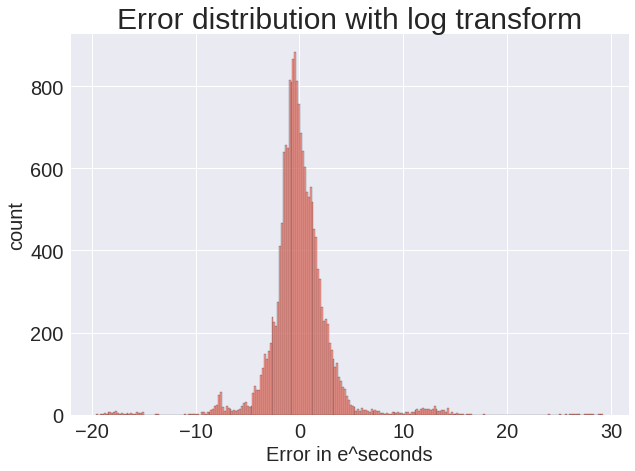

In [10]:
y_true = pd.DataFrame(Y)
y_pred = pd.DataFrame(y_pred)
df_error = pd.concat([y_true, y_pred], axis=1)
df_error.columns = ['y_true', 'y_pred']
df_error.reset_index(inplace=True)
df_error['error'] = df_error['y_true'] - df_error['y_pred']

fig, ax = plt.subplots(figsize=(10, 7))
# df_error.plot.hist(x='index', y='error', figsize=(10,5), ax=ax, bins=10)
sns.histplot(data=df_error, x='error', ax=ax, color='salmon')
ax.set_title('Error distribution with log transform', size=30)
ax.set_ylabel('count', fontsize=20)
ax.set_xlabel('Error in e^seconds', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


In [11]:
# cols = df_data.columns.tolist()
# cols.remove('time_diff')
# cols = cols + ['time_diff']
# df_data = df_data[cols]

# categorial = ['case LoanGoal']
# numerical = ['case RequestedAmount']
# df_data.drop(categorial, axis=1).drop(numerical, axis=1)


In [12]:
# model.summary()
